In [1]:
!pip install torchviz
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
from torchviz import make_dot
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import os
import matplotlib.pyplot as plt
import numpy as np # we always love numpy
import time

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [65]:
import numpy as np
import pandas as pd
import glob
waldo_images = glob.glob("C:/Users/nshuster/Desktop/Hey-Waldo/64/waldo/*.jpg")
print(len(waldo_images))
not_waldo_images = glob.glob("C:/Users/nshuster/Desktop/Hey-Waldo/64/notwaldo/*.jpg")[4000:]

print(len(not_waldo_images))
labels = []
for image in waldo_images:
    labels.append((image, 0))
for image in not_waldo_images:
    labels.append([image, 1])
a = np.asarray(labels)
pd.DataFrame(a).to_csv("C:/Users/nshuster/Desktop/labels.csv")

39
1337


In [3]:
import matplotlib.image as mpimg

csv_frame = pd.read_csv("C:/Users/nshuster/Desktop/labels.csv")
n = 65
image_name = csv_frame.iloc[n, 1]
image_label = csv_frame.iloc[n, 2]

print(image_name)
print(image_label)

def show_label(image, label):
    plt.imshow(image)
    plt.title(label)

plt.figure()
show_label(mpimg.imread(image_name), image_label)

C:/Users/nshuster/Desktop/Hey-Waldo/64/notwaldo\4_7_15.jpg
1


In [4]:
from skimage import io, transform

class WaldoDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = os.path.join(self.root_dir,self.annotations_frame.iloc[idx, 1])
        image = io.imread(img_name)
        label = self.annotations_frame.iloc[idx, 2]
        label = label.astype('long')
        #annotations = self.annotations_frame.iloc[idx, 2]
        #annotations = np.array([annotations])
        #annotations = annotations.astype('float').reshape(-1, 2)
        sample = {'image': image, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
            'label': torch.tensor(label)}

In [5]:
waldo_dataset = WaldoDataset(csv_file="C:/Users/nshuster/Desktop/labels.csv", root_dir="C:/Users/nshuster/Desktop/Hey-Waldo/64/", transform=ToTensor())
fig = plt.figure()

print(waldo_dataset)

In [6]:
image_dims = [3, 64, 64]
classes = ('notwaldo', 'waldo')
print(len(waldo_dataset))
class MyCNN(nn.Module):
    # The init funciton in Pytorch classes is used to keep track of the parameters of the model
    # specifically the ones we want to update with gradient descent + backprop
    # So we need to make sure we keep track of all of them here
    def __init__(self):
        super(MyCNN, self).__init__()
        # layers defined here

        # Make sure you understand what this convolutional layer is doing.
        # E.g., considering looking at help(nn.Conv2D).  Draw a picture of what
        # this layer does to the data.

        # note: image_dims[0] will be 3 as there are 3 color channels (R, G, B)
        num_kernels = 16
        self.conv1 = nn.Conv2d(image_dims[0], num_kernels, kernel_size=5, stride=1, padding=2)

        # Make sure you understand what this MaxPool2D layer is doing.
        # E.g., considering looking at help(nn.MaxPool2D).  Draw a picture of
        # what this layer does to the data.

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # maxpool_output_size is the total amount of data coming out of that
        # layer.  We have an exercise that asks you to explain why the line of
        # code below computes this quantity.
        self.maxpool_output_size = int(num_kernels * (image_dims[1] / 2) * (image_dims[2] / 2))

        # Add on a fully connected layer (like in our MLP)
        # fc stands for fully connected
        fc1_size = 64
        self.fc1 = nn.Linear(self.maxpool_output_size, fc1_size)

        # we'll use this activation function internally in the network
        self.activation_func = torch.nn.ReLU()

        # Convert our fully connected layer into outputs that we can compare to the result
        fc2_size = len(classes)
        self.fc2 = nn.Linear(fc1_size, fc2_size)

        # Note: that the output will not represent the probability of the
        # output being in each class.  The loss function we will use
        # `CrossEntropyLoss` will take care of convering these values to
        # probabilities and then computing the log loss with respect to the
        # true label.  We could break this out into multiple steps, but it turns
        # out that the algorithm will be more numerically stable if we do it in
        # one go.  We have included a cell to show you the documentation for
        # `CrossEntropyLoss` if you'd like to check it out.
        
    # The forward function in the class defines the operations performed on a given input to the model
    # and returns the output of the model
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.activation_func(x)
        # this code flattens the output of the convolution, max pool,
        # activation sequence of steps into a vector
        x = x.view(-1, self.maxpool_output_size)
        x = self.fc1(x)
        x = self.activation_func(x)
        x = self.fc2(x)
        return x

    # The loss function (which we chose to include as a method of the class, but doesn't need to be)
    # returns the loss and optimizer used by the model
    def get_loss(self, learning_rate):
      # Loss function
        loss = nn.CrossEntropyLoss()
      # Optimizer, self.parameters() returns all the Pytorch operations that are attributes of the class
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        return loss, optimizer

# Define what device we want to use
device = 'cpu' # 'cpu' if we want to not use the gpu
# Initialize the model, loss, and optimization function
net = MyCNN()


# This tells our model to send all of the tensors and operations to the GPU (or keep them at the CPU if we're not using GPU)
net.to(device)

1376


MyCNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=64, bias=True)
  (activation_func): ReLU()
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)

In [60]:
"""print(type(waldo_dataset))
reduced_waldo_dataset = []
for i in range(100):
  reduced_waldo_dataset.append(waldo_dataset[i])"""


"""reduced_train_size = int(0.75 * len(reduced_waldo_dataset))
reduced_test_size = len(reduced_waldo_dataset) - reduced_train_size
reduced_waldo_dataset_train, reduced_waldo_dataset_test = torch.utils.data.random_split(reduced_waldo_dataset, [reduced_train_size, reduced_test_size])
"""



train_size = int(0.75 * len(waldo_dataset))
test_size = len(waldo_dataset) - train_size
waldo_dataset_train, waldo_dataset_test = torch.utils.data.random_split(waldo_dataset, [train_size, test_size])

train_loader = DataLoader(waldo_dataset_train, batch_size=1)
test_loader = DataLoader(waldo_dataset_test, batch_size=1)

device = torch.device('cpu')
learning_rate = 1e-2
n_epochs = 1

def train_model(net):
    """ Train a the specified network.

        Outputs a tuple with the following four elements
        train_hist_x: the x-values (batch number) that the training set was 
            evaluated on.
        train_loss_hist: the loss values for the training set corresponding to
            the batch numbers returned in train_hist_x
        test_hist_x: the x-values (batch number) that the test set was 
            evaluated on.
        test_loss_hist: the loss values for the test set corresponding to
            the batch numbers returned in test_hist_x
    """ 
    loss, optimizer = net.get_loss(learning_rate)
    # Define some parameters to keep track of metrics
    print_every = 50
    idx = 0
    #print("started training...")
    train_hist_x = []
    train_loss_hist = []
    test_hist_x = []
    test_loss_hist = []

    training_start_time = time.time()
    # Loop for n_epochs
    for epoch in range(n_epochs):
        #print("epoch %(e)d" % {"e":epoch})
        running_loss = 0.0
        start_time = time.time()
        
        #print("about to enumerate")
        print(len(train_loader))
        for i, data in enumerate(train_loader):
          #print(i, data)
            #print("enumerating...")
            # Get inputs in right form
           # print(data)
            #print(data['image']) #rint(data['inputs'])
            inputs, labels = data['image'], data['label']
            #print(inputs)
          #print(labels)
            inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.long)
          
            #print("initializing optimizer...")
          # In Pytorch, We need to always remember to set the optimizer gradients to 0 before we recompute the new gradients
            optimizer.zero_grad()
            
            #print("about to forward pass")

          # Forward pass
            #inputs = inputs.unsqueeze(0)
            outputs = net(inputs)
          
            #print("forward passed")
          # Compute the loss and find the loss with respect to each parameter of the model
            loss_size = loss(outputs, labels)
            loss_size.backward()
            #print("calculate loss")
          # Change each parameter with respect to the recently computed loss.
            optimizer.step()

          # Update statistics
            running_loss += loss_size.data.item()
            #print("updated loss")
          # Print every 20th batch of an epoch
            if (i % print_every) == print_every-1:
                print("Epoch {}, Iteration {}\t train_loss: {:.2f} took: {:.2f}s".format(
                    epoch + 1, i+1,running_loss / print_every, time.time() - start_time))
              # Reset running loss and time
                train_loss_hist.append(running_loss / print_every)
                train_hist_x.append(idx)
                running_loss = 0.0
                start_time = time.time()
                idx += 1

        # At the end of the epoch, do a pass on the test set
            total_test_loss = 0
            #print("test set pass")
            for i, data in enumerate(test_loader, 0):
                inputs, labels = data['image'], data['label']
                #print("made it past enumerator")
            # Wrap tensors in Variables
                inputs, labels = Variable(inputs).to(device, dtype=torch.float), Variable(labels).to(device, dtype=torch.long)

            # Forward pass
                test_outputs = net(inputs)
                test_loss_size = loss(test_outputs, labels)
                total_test_loss += test_loss_size.data.item()
            test_loss_hist.append(total_test_loss / len(test_loader))
            test_hist_x.append(idx)
            print("Validation loss = {:.2f}".format(
                total_test_loss / len(test_loader)))

        print("Training finished, took {:.2f}s".format(
        time.time() - training_start_time))
        return train_hist_x, train_loss_hist, test_hist_x, test_loss_hist

In [61]:
train_hist_x, train_loss_hist, test_hist_x, test_loss_hist = train_model(net)

1032
Validation loss = 0.13
Validation loss = 0.13
Validation loss = 0.13
Validation loss = 0.13
Validation loss = 0.13
Validation loss = 0.13
Validation loss = 0.13
Validation loss = 0.13
Validation loss = 0.13
Validation loss = 0.13
Validation loss = 0.13
Validation loss = 0.13
Validation loss = 0.13
Validation loss = 0.13
Validation loss = 0.13
Validation loss = 0.13
Validation loss = 0.13
Validation loss = 0.13
Validation loss = 0.13
Validation loss = 0.13
Validation loss = 0.13
Validation loss = 0.13
Validation loss = 0.13
Validation loss = 0.13
Validation loss = 0.13
Validation loss = 0.14
Validation loss = 0.14
Validation loss = 0.14
Validation loss = 0.14
Validation loss = 0.14
Validation loss = 0.14
Validation loss = 0.13
Validation loss = 0.13
Validation loss = 0.13
Validation loss = 0.13
Validation loss = 0.13
Validation loss = 0.13
Validation loss = 0.13
Validation loss = 0.13
Validation loss = 0.13
Validation loss = 0.13
Validation loss = 0.13
Validation loss = 0.13
Valida

Validation loss = 0.14
Validation loss = 0.14
Validation loss = 0.14
Validation loss = 0.14
Validation loss = 0.15
Validation loss = 0.15
Validation loss = 0.15
Epoch 1, Iteration 350	 train_loss: 0.24 took: 92.31s
Validation loss = 0.15
Validation loss = 0.15
Validation loss = 0.15
Validation loss = 0.15
Validation loss = 0.15
Validation loss = 0.15
Validation loss = 0.15
Validation loss = 0.14
Validation loss = 0.14
Validation loss = 0.14
Validation loss = 0.14
Validation loss = 0.14
Validation loss = 0.14
Validation loss = 0.14
Validation loss = 0.14
Validation loss = 0.14
Validation loss = 0.14
Validation loss = 0.14
Validation loss = 0.13
Validation loss = 0.13
Validation loss = 0.13
Validation loss = 0.13
Validation loss = 0.13
Validation loss = 0.13
Validation loss = 0.13
Validation loss = 0.13
Validation loss = 0.13
Validation loss = 0.13
Validation loss = 0.13
Validation loss = 0.13
Validation loss = 0.13
Validation loss = 0.13
Validation loss = 0.13
Validation loss = 0.13
Val

Validation loss = 0.14
Validation loss = 0.14
Validation loss = 0.14
Validation loss = 0.14
Validation loss = 0.14
Validation loss = 0.14
Validation loss = 0.14
Validation loss = 0.14
Validation loss = 0.14
Validation loss = 0.14
Validation loss = 0.15
Validation loss = 0.15
Validation loss = 0.15
Validation loss = 0.15
Validation loss = 0.15
Validation loss = 0.15
Validation loss = 0.15
Epoch 1, Iteration 700	 train_loss: 0.01 took: 100.46s
Validation loss = 0.15
Validation loss = 0.15
Validation loss = 0.15
Validation loss = 0.15
Validation loss = 0.15
Validation loss = 0.15
Validation loss = 0.15
Validation loss = 0.15
Validation loss = 0.15
Validation loss = 0.15
Validation loss = 0.15
Validation loss = 0.15
Validation loss = 0.15
Validation loss = 0.14
Validation loss = 0.14
Validation loss = 0.14
Validation loss = 0.14
Validation loss = 0.14
Validation loss = 0.14
Validation loss = 0.14
Validation loss = 0.14
Validation loss = 0.14
Validation loss = 0.13
Validation loss = 0.13
Va

Validation loss = 0.14
Validation loss = 0.14
Validation loss = 0.14
Validation loss = 0.14
Validation loss = 0.14
Validation loss = 0.14
Validation loss = 0.14
Validation loss = 0.14
Validation loss = 0.14
Validation loss = 0.14
Training finished, took 1879.68s


In [62]:
#print("y_true: " + str(np.argmawaldo_dataset_test, axis=-1)))
print("y_true: " + str([x['label'] for x in waldo_dataset_test]))

outputs = net(test_loader)


#def acc(y_true, y_pred):
#    return np.equal(np.argmax(y_true, axis=-1), np.argmax(y_pred, axis=-1)).mean()

#print("accuracy: " + str(acc(y_test, y_pred)))

y_true: [tensor(1, dtype=torch.int32), tensor(1, dtype=torch.int32), tensor(1, dtype=torch.int32), tensor(0, dtype=torch.int32), tensor(1, dtype=torch.int32), tensor(1, dtype=torch.int32), tensor(1, dtype=torch.int32), tensor(1, dtype=torch.int32), tensor(1, dtype=torch.int32), tensor(1, dtype=torch.int32), tensor(1, dtype=torch.int32), tensor(1, dtype=torch.int32), tensor(1, dtype=torch.int32), tensor(1, dtype=torch.int32), tensor(1, dtype=torch.int32), tensor(1, dtype=torch.int32), tensor(1, dtype=torch.int32), tensor(1, dtype=torch.int32), tensor(1, dtype=torch.int32), tensor(1, dtype=torch.int32), tensor(1, dtype=torch.int32), tensor(1, dtype=torch.int32), tensor(0, dtype=torch.int32), tensor(1, dtype=torch.int32), tensor(1, dtype=torch.int32), tensor(1, dtype=torch.int32), tensor(1, dtype=torch.int32), tensor(1, dtype=torch.int32), tensor(1, dtype=torch.int32), tensor(1, dtype=torch.int32), tensor(1, dtype=torch.int32), tensor(1, dtype=torch.int32), tensor(1, dtype=torch.int32), t

TypeError: conv2d(): argument 'input' (position 1) must be Tensor, not DataLoader

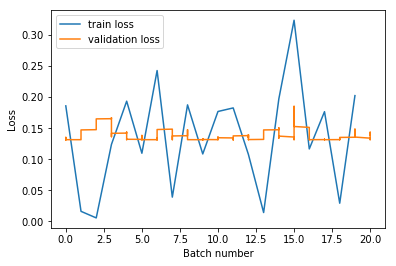

right waldos = 29000.0
Train accuracy is 0.971899224806
right waldos = 10000.0
Test accuracy is 0.970930232558


In [64]:
def get_accuracy(net, loader):
    n_correct = 0
    n_total = 0
    n_waldo = 0
    n_correct_waldo = 0.001
    for i, data in enumerate(loader, 0):
        # Get inputs in right form
        
        inputs, labels = data['image'], data['label']
        inputs, labels = Variable(inputs).to(device, dtype=torch.float), Variable(labels).to(device, dtype=torch.long)
        
        
        # Forward pass
        outputs = net(inputs)
        if data['label'] == torch.tensor([0], dtype=torch.int, device=device):
            n_waldo += 1
            n_correct_waldo += np.sum(np.argmax(outputs.cpu().detach().numpy(), axis=1) == labels.cpu().numpy())
            #if outputs['label'] == data['label']:
            #    n_correct_waldo += 1
        #if tensor.get(labels, 0) == 1:
        #    print(inputs)
        
        #for i in outputs:
        #   print(np.argmax(outputs.cpu().detach().numpy()))
            
        
        #waldo_correct = for i in(np.argmax(outputs.cpu().detach().numpy(), axis=1) == labels.cpu().numpy()))
        n_correct += np.sum(np.argmax(outputs.cpu().detach().numpy(), axis=1) == labels.cpu().numpy())
        n_total += labels.shape[0]
    
    print("right waldos = " + str(n_waldo/n_correct_waldo))
    return n_correct/n_total

plt.plot(train_hist_x,train_loss_hist)
plt.plot(test_hist_x,test_loss_hist)
plt.legend(['train loss', 'validation loss'])
plt.xlabel('Batch number')
plt.ylabel('Loss')
plt.show()

print("Train accuracy is", get_accuracy(net, train_loader))
print("Test accuracy is", get_accuracy(net, test_loader))